 #### About
 1. CycleGAN attempts to learn a mapping from one dataset to another like a dataset of plants to dataset of faces.
 2. It does this with two generators G and F and two discriminators Dx and Dy.
 3. G attempts to turn dataset A into dataset B and F attempts to turn dataset B into dataset A.
 4. Dx is used to differentiate real images sampled from Dataset A and images generated by generator F. F is updated to get better at fooling Dx
 5. Dy is used to differentiate real images sampled from Dataset B and images generated by generator G. G is updated to get better at fooling Dy.
 6. Introduction of cycle loss is made to ensure an image that is yielded by generator can be mapped back to original image by other generator i.e F(G(x)) - x and G(F(y)) - y. Two cycles of Generators.
 7. Introduction of identity loss is made to help preserve tint, contrast and color shade. It ensures that when an image of target class is given, Generator yields the same image. F(x) - x and G(y) - y.
 8. A series of conv layers and residual layers are used in generator to map one image to another.
 9. PatchGAN architecture is used to classify images via Discriminator.
 10. Reflection padding is used in architecture instead of zero padding to reduce artifacts.
 11. The generator consists of encoder and decoder. It downsamples or encode the input image then interpret the encoding with series of residual blocks having skip connections. After this, Upsampling is being done to decode the representation to the size of the fake image.
 12. Instance normalisation is used instead of batch normalisation which results in better image generated by operating across image channels.
 13. Discriminator uses a PatchGAN in modification to the regular GAN architecture. The regular GAN maps an input image to single scalar output in range of 0 to 1 indicating the image being real or fake via probability. Whereas PatchGAN provides a matrix as output where each element of the matrix signifies whether its corresponding patch is real or fake. The receptive field of discriminator is 70*70 in Cycle GAN.
 ![cycle_gan](cycle_gan.png)
 14. To reduce model oscillation, Replay buffer method is implemented. The discriminator is updated using a history of generated images rather than the ones produced by the latest generators. An image buffer to store previous created images is stored.

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

In [24]:
#importing modules
import os
import sys
import numpy as np
import time
import glob
import random
from PIL import Image
import math
import itertools
import scipy
import copy
import shutil

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline



In [ ]:
#unzipping the dataset
os.chdir('/content/drive/MyDrive/datasets/')
!unzip apple2orange.zip

In [6]:
#utility functions
def create_dir(path):
    if not isinstance(path, (list,tuple)):
        paths = [path]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)

def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

dataset_dir = '/home/suraj/ClickUp/Jan-Feb/data/apple2orange/'
apple_train_dir = dataset_dir + '/trainA/'
orange_train_dir = dataset_dir + '/trainB/'
apple_val_dir = dataset_dir + '/testA/'
orange_val_dir = dataset_dir + '/testB/'


In [7]:
class GanDataset(Dataset):
    def __init__(self, trainA_path,trainB_path, transform = None, unaligned = False):
        self.transform = transform
        self.unaligned = unaligned

        self.file_names_A = sorted(glob.glob(trainA_path+"*.*"))
        self.file_names_B = sorted(glob.glob(trainB_path+"*.*"))

    
    def __getitem__(self,index):
        image_A = Image.open(self.file_names_A[index])
        if self.unaligned:
            image_B = Image.open(self.file_names_B[random.randint(0,len(self.file_names_B)-1)])
        else:
            image_B = Image.open(self.file_names_B[index])
        # if image is grayscale , then convert to RGB
        if image_A.mode!="RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode!="RGB":
            image_B = convert_to_rgb(image_B)

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)

        return {"first_image":image_A, "second_image":image_B}

    
    def __len__(self):
        return max(len(self.file_names_A),len(self.file_names_B))

In [8]:


transform = transforms.Compose([
    transforms.Resize((128, 128), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


train_dataset = GanDataset(apple_train_dir,orange_train_dir,transform= transform)
val_dataset = GanDataset(apple_val_dir,orange_val_dir,transform= transform)

/home/suraj/anaconda3/envs/torch_dl/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [13]:
train_dataset.__getitem__(6)

{'first_image': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.9059, -0.7725, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9922]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.9059, -0.7725, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.9922]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1

In [14]:
val_dataset.__getitem__(5)

{'first_image': tensor([[[0.5059, 0.5059, 0.5059,  ..., 0.4980, 0.4980, 0.4980],
          [0.5059, 0.5059, 0.5059,  ..., 0.4980, 0.4980, 0.4980],
          [0.5059, 0.5059, 0.5059,  ..., 0.4980, 0.4980, 0.4980],
          ...,
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059],
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059],
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059]],
 
         [[0.5059, 0.5059, 0.5059,  ..., 0.5137, 0.5137, 0.5137],
          [0.5059, 0.5059, 0.5059,  ..., 0.5137, 0.5137, 0.5137],
          [0.5059, 0.5059, 0.5059,  ..., 0.5137, 0.5137, 0.5137],
          ...,
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059],
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059],
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059]],
 
         [[0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059],
          [0.5059, 0.5059, 0.5059,  ..., 0.5059, 0.5059, 0.5059],
          [0.5059, 0.5059

In [21]:
# creating data laoder
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset,batch_size=2,shuffle=True,num_workers=4)

In [22]:
for batch in train_loader:
    print(batch['first_image'].shape, batch['second_image'].shape)
    break

torch.Size([2, 3, 128, 128]) torch.Size([2, 3, 128, 128])


In [17]:
channels = 3,
img_size= 128

In [18]:
# visualisation utils
def show_img(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, channels, img_size, img_size)
    return x


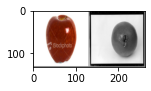

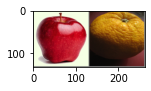

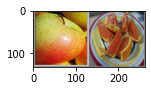

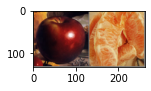

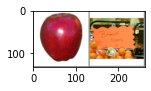

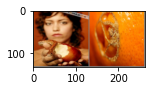

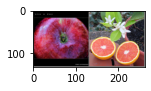

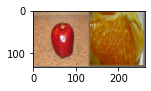

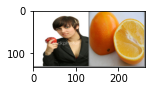

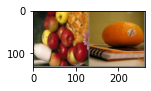

In [19]:
#visualizing
for i in range(10):
    data = train_dataset.__getitem__(i)
    show_img(make_grid([data["first_image"],data["second_image"]]), size=2)

#### Model Architecture
- We create two discriminators(One with Patch GAN and without PatchGAN) per generator.

In [20]:
class Discriminator_NonPatch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(64,128, kernel_size=4, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128,256, kernel_size=4,stride=2)
        self.batch_norm2 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256,512, kernel_size=4,stride=2)
        self.batch_norm3 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512,512, kernel_size=6, stride=1)
        self.head = nn.Linear(512,1)

    def forward(self,input):
        x = F.leaky_relu(self.conv1(input),negative_slope=0.2)
        x = F.leaky_relu(self.batch_norm1(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.batch_norm2(self.conv3(x)),negative_slope=0.2)
        x = F.leaky_relu(self.batch_norm3(self.conv4), negative_slope=0.2)
        x = F.leaky_relu(self.conv5(x), negative_slope=0.2)

        x = x.view(x.size(0),-1)
        x = self.head(x)
        return F.sigmoid(x) # prob of discriminator

In [23]:
# Discriminator with Patch GAN - which takes 70*70 image as input
class Discriminator_Patch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(64,128, kernel_size=4, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128,256, kernel_size=4,stride=2)
        self.batch_norm2 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256,512, kernel_size=4,stride=2)
        self.batch_norm3 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512,512, kernel_size=6, stride=1)
        self.head = nn.Linear(512,1)

    def forward(self,input):
        x = F.leaky_relu(self.conv1(input),negative_slope=0.2)
        x = F.leaky_relu(self.batch_norm1(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.batch_norm2(self.conv3(x)),negative_slope=0.2)
        x = F.leaky_relu(self.batch_norm3(self.conv4), negative_slope=0.2)
        x = F.leaky_relu(self.conv5(x), negative_slope=0.2)

        x = x.view(x.size(0),-1)
        x = self.head(x)
        return F.sigmoid(x) # prob of discriminator

In [25]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # nomenclatures as per paper
        #c7s1-32
        self.r1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        #d64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #d128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        #R128
        self.r4 = nn.ReflectionPad2d(1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.r5 = nn.ReflectionPad2d(1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)
        
        #R128
        self.r6 = nn.ReflectionPad2d(1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.r7 = nn.ReflectionPad2d(1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(128)
        
        #R128
        self.r8 = nn.ReflectionPad2d(1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.r9 = nn.ReflectionPad2d(1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn9 = nn.BatchNorm2d(128)
        
        #R128
        self.r10 = nn.ReflectionPad2d(1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn10 = nn.BatchNorm2d(128)
        
        self.r11 = nn.ReflectionPad2d(1)
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn11 = nn.BatchNorm2d(128)
        
        #R128
        self.r12 = nn.ReflectionPad2d(1)
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn12 = nn.BatchNorm2d(128)
        
        self.r13 = nn.ReflectionPad2d(1)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn13 = nn.BatchNorm2d(128)
        
        #R128
        self.r14 = nn.ReflectionPad2d(1)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn14 = nn.BatchNorm2d(128)
        
        self.r15 = nn.ReflectionPad2d(1)
        self.conv15 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn15 = nn.BatchNorm2d(128)
        
        #u64
        self.uconv16 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn16 = nn.BatchNorm2d(64)
        
        #u32
        self.uconv17 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn17 = nn.BatchNorm2d(32)
        
        #c7s1-3
        self.r18 = nn.ReflectionPad2d(3)
        self.conv18 = nn.Conv2d(32, 3, kernel_size=7, stride=1)
        self.bn18 = nn.BatchNorm2d(3)
        
    def forward(self, input):
        
        #c7s1-32
        x = F.leaky_relu(self.bn1(self.conv1(self.r1(input))), negative_slope=0.2)
        
        #d64
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        
        #d128
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        
        #R128
        x1 = F.leaky_relu(self.bn4(self.conv4(self.r4(x))), negative_slope=0.2)
        x1 = F.leaky_relu(self.bn5(self.conv5(self.r5(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = F.leaky_relu(self.bn6(self.conv6(self.r6(x))), negative_slope=0.2)
        x1 = F.leaky_relu(self.bn7(self.conv7(self.r7(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = F.leaky_relu(self.bn8(self.conv8(self.r8(x))), negative_slope=0.2)
        x1 = F.leaky_relu(self.bn9(self.conv9(self.r9(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = F.leaky_relu(self.bn10(self.conv10(self.r10(x))), negative_slope=0.2)
        x1 = F.leaky_relu(self.bn11(self.conv11(self.r11(x1))), negative_slope=0.2)
        
        x = x + x1
       
        #R128
        x1 = F.leaky_relu(self.bn12(self.conv12(self.r12(x))), negative_slope=0.2)
        x1 = F.leaky_relu(self.bn13(self.conv13(self.r13(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = F.leaky_relu(self.bn14(self.conv14(self.r14(x))), negative_slope=0.2)
        x1 = F.leaky_relu(self.bn15(self.conv15(self.r15(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #u64
        x = F.leaky_relu(self.bn16(self.uconv16(x)), negative_slope=0.2)
        
        #u32
        x = F.leaky_relu(self.bn17(self.uconv17(x)), negative_slope=0.2)
        
        #c7s1-3
        x = F.leaky_relu(self.bn18(self.conv18(self.r18(x))), negative_slope=0.2)
        
        return F.tanh(x)

        


In [26]:
# initialising convolution layer weights to N(0,0.02) as per paper
def initialise_conv_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

In [27]:
# function to divide 128*128 image into multiple 70*70 images. These images are passed through our discriminator and scores are averages

def pass_image_through_discriminator_patchgan(discriminator_patch,image):
    score, k = 0, Variable(torch.zeros(1)).type(torch.FloatTensor)
    xp,yp = 0,0
    x,y = 70,70
    offset = 15

    while x<128:
        while y<128:
            k+=1
            score += discriminator_patch(image[:,:,xp:x,yp:y])
            yp+=offset
            y+=offset
        
        xp+=offset
        x+= offset
    
    return score/k

#### Replay Buffer

Replay buffer is used to train the discriminator. Generated images are added to the replay buffer and sampled from it. The replay buffer returns the newly added image with a probability of 0.5 otherwise sends and older generated images and replaces the older image with newly generated image.

This is done to reduce model oscillation

In [ ]:
# Defining replay buffer
class ReplayBuffer :
    # An image buffer that stores 100 previously generated images.
    def __init__(self, max_size=100):
        assert max_size >0, "Empty buffer"
        self.max_size = max_size
        self.data = []

    def push_and_pop(self,data):
        output = []
        for element in self.data:
            element = torch.unsqueeze(element,0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                output.append(element)
            else:
                # return newly added image with prob of 0.5
                if random.uniform(0,1) >0.5:
                    i = random.randint(0,self.max_size-1)
                    output.append(self.data[i].clone())
                    self.data[i]= element # replaces the older image with newly generated image
                else:
                    output.append(element)
        
        return Variable(torch.cat(output)) # concat the given seq tensors in the given dim